# Exercice technique classification 
* Robin Masliah

### Préambule :

Dans cet exercice il s'agit de faire de la recommandation de projet.
Prédire variable "contrib".

### Description des données :
Le dataset est constitué de 25 colonnes dont
- contrib : variable cible, 1 veut dire que l’utilisateur a participé au projet recommandé, 0 veut dire que ce n’est pas (encore) le cas.

Et 23 variables qui constituent l’ensemble des variables d’entrée du problème.

Pour répondre à la question je ferai deux modèles pour les challenger l'un à l'autre.    

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from datetime import datetime
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sqlalchemy import create_engine

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, average_precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./recos_training.csv', sep=',')
df1 = pd.read_csv('./recos_test.csv', sep=',')

In [3]:
df.columns

Index(['id', 'owner_friend', 'dist', 'nb_copledgers', 'amount_copledgers',
       'desc_score_mean', 'amount_friends', 'nb_friends', 'same_owner',
       'music', 'live-performance', 'journalism', 'book-and-publishing',
       'design-and-innovation', 'film-and-video', 'style', 'photography',
       'social', 'web-and-tech', 'education', 'art', 'adventure-and-sport',
       'food', 'ecology', 'contrib'],
      dtype='object')

In [4]:
df.describe()

,id,owner_friend,dist,nb_copledgers,amount_copledgers,desc_score_mean,amount_friends,nb_friends,same_owner,music,...,style,photography,social,web-and-tech,education,art,adventure-and-sport,food,ecology,contrib
count,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,...,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000,13866.000000
mean,6932.500000,0.000072,0.208638,0.022634,64.392399,0.695078,0.095630,0.001947,0.005770,0.002615,...,0.000630,0.001136,0.003102,0.000359,0.002836,0.001016,0.001239,0.001631,0.003068,0.026395
std,4002.913751,0.008492,0.356570,0.074816,410.841301,0.385190,3.331208,0.048747,0.075741,0.014111,...,0.007612,0.010867,0.014353,0.007778,0.018050,0.007564,0.011297,0.009210,0.014694,0.160314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3466.250000,0.000000,0.000000,0.000000,0.000000,0.731103,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6932.500000,0.000000,0.000000,0.000000,0.000000,0.904186,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10398.750000,0.000000,0.391770,0.000000,0.000000,0.930128,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,13865.000000,1.000000,1.000000,0.988600,23045.000000,0.982963,280.000000,3.000000,1.000000,0.214298,...,0.200008,0.333333,0.230782,0.333333,0.333356,0.187512,0.260872,0.153849,0.285722,1.000000


In [5]:
df.contrib.unique()

array([ 0.,  1.])

In [6]:
df.head()

,id,owner_friend,dist,nb_copledgers,amount_copledgers,desc_score_mean,amount_friends,nb_friends,same_owner,music,...,style,photography,social,web-and-tech,education,art,adventure-and-sport,food,ecology,contrib
0,0,0.0,0.079014,0.0000,0.0,0.893995,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.017690,0.0,0.0,0.0,0.0
1,1,0.0,0.945677,0.0049,339.0,0.861315,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.011792,0.0,0.0,0.0,0.0
2,2,0.0,0.000000,0.0000,0.0,0.887326,20.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,3,0.0,0.000000,0.2469,36.0,0.886949,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,4,0.0,0.000000,0.0700,1875.0,0.000000,80.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0


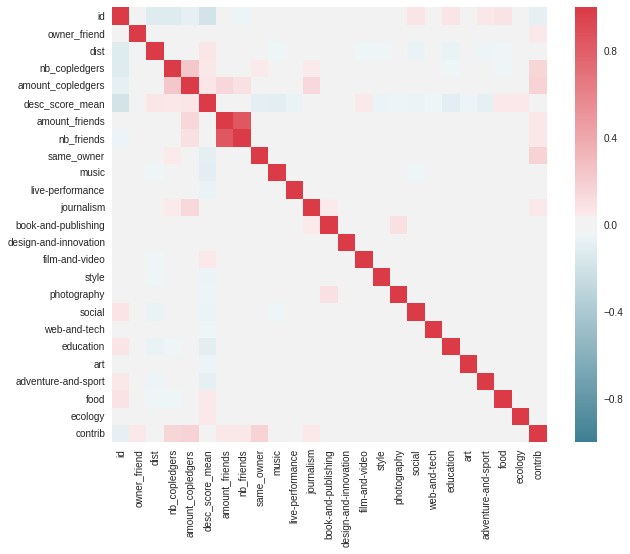

In [7]:
# Etude des corrélations entre les features
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

* Les features sont glogalement très peu corrélées entres elles.

In [8]:
# Je retire id pour ne pas induire le modèle en erreur.
train = df.copy()
test = df1.copy()
del train['id']
del test['id']

In [9]:
# SQL engine pour pouvoir explorer les données à l'oeil nu rapidement à titre observatoire.
engine = create_engine('sqlite:///:memory:')
test.to_sql('table', engine)
pd.read_sql_table('table', engine)
pd.read_sql_query('select * from "table" limit 5', con=engine)

,index,owner_friend,dist,nb_copledgers,amount_copledgers,desc_score_mean,amount_friends,nb_friends,same_owner,music,...,style,photography,social,web-and-tech,education,art,adventure-and-sport,food,ecology,contrib
0,0,0.0,0.538569,0.0,0.0,0.88178,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,1,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,2,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.062504,0.0,0.0,0.0,0.0
3,3,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,4,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.062504,0.0,0.0,0.0,0.0


In [10]:
# Proportion de 1 et 0 dans le test set
print(pd.read_sql_query('select count(*) as Nb_1 from "table" where contrib = "1.0"', con=engine))
print('\n')
print(pd.read_sql_query('select count(*) as Nb_0 from "table" where contrib = "0.0"', con=engine))

   Nb_1
0    36


   Nb_0
0  4587


* La classe est très déséquilibrée il sera donc difficile de prédire les vrais positifs.

In [11]:
y_train = train['contrib']
X_train = train.copy()
del X_train['contrib']

In [12]:
y_test = test['contrib']
X_test = test.copy()
del X_test['contrib']

In [13]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Affichage dans l'ordre des features importantes
print("Features :")

for i in range(0, len(X_train.columns)):
    print(i + 1, X_train.columns[i])

print("\n")
print("Features importances rankées:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Features :
1 owner_friend
2 dist
3 nb_copledgers
4 amount_copledgers
5 desc_score_mean
6 amount_friends
7 nb_friends
8 same_owner
9 music
10 live-performance
11 journalism
12 book-and-publishing
13 design-and-innovation
14 film-and-video
15 style
16 photography
17 social
18 web-and-tech
19 education
20 art
21 adventure-and-sport
22 food
23 ecology


Features importances rankées:
1. feature 5 (0.303530)
2. feature 3 (0.173360)
3. feature 4 (0.151257)
4. feature 2 (0.081997)
5. feature 17 (0.048420)
6. feature 23 (0.042961)
7. feature 8 (0.034783)
8. feature 22 (0.025987)
9. feature 11 (0.024978)
10. feature 20 (0.020123)
11. feature 12 (0.019507)
12. feature 9 (0.019201)
13. feature 14 (0.013125)
14. feature 19 (0.008119)
15. feature 21 (0.006543)
16. feature 6 (0.006416)
17. feature 15 (0.005036)
18. feature 13 (0.004840)
19. feature 7 (0.003704)
20. feature 1 (0.002466)
21. feature 16 (0.002277)
22. feature 10 (0.001192)
23. feature 18 (0.000177)


* Les features catégories telles qu'elles sont ne semblent, en général, pas avoir une grande influence sur le modèle.
* Il serait intéréssant de savoir par exemple à combien de projet en tout un utilisateur à contribué.

## Random Forest

In [24]:
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=10,
                            n_jobs=-1, random_state=3, verbose=0, 
                            class_weight='balanced')
rf.fit(X_train, y_train)
scores = cross_val_score(rf, X_train, y_train, cv=15)
y_pred = rf.predict(X_test)

### Choix des paramètres :
* **n_estimators** : Le nombre d'arbres.
* **criterion** : critère de séparation des branche basé sur Gini. Gini mesure avec quelle fréquence un élément aléatoire de l'ensemble serait mal classé si son étiquette était sélectionnée aléatoirement depuis la distribution des étiquettes dans le sous-ensemble.
* **max_depth** : Profondeur maximale des arbres.
* **n_jobs** : à -1 pour paralléliser les calculs sur l'ensemble des coeurs de la machine.
* **random_state** : La seed du générateur de nombres pseudo-aléatoires à utiliser lors du brassage des données.
* **class_weight** : à "balanced" utilise les valeurs de y pour ajuster automatiquement les poids inversement proportionnels aux fréquences de classe dans les données d'entrée.

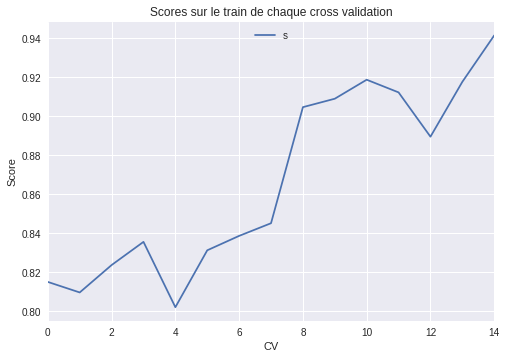

In [25]:
# Scores sur cross validation
scores = pd.DataFrame(scores)
scores.plot()

plt.xlabel('CV')
plt.ylabel('Score')
plt.title("Scores sur le train de chaque cross validation")

plt.axis()
plt.legend("scores", loc='upper center')
plt.show()

In [21]:
y_pred = pd.DataFrame(y_pred)

In [22]:
y_pred.describe()

,0
count,4623.000000
mean,0.083279
std,0.276334
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### Evaluation du modèle

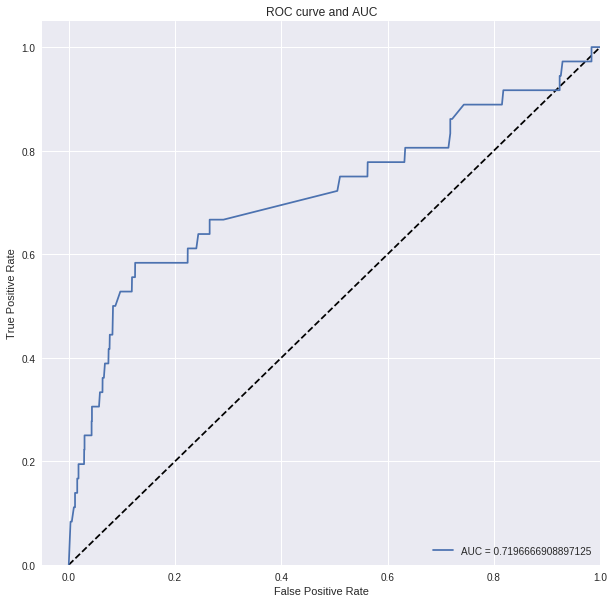

In [19]:
# overall accuracy
acc = rf.score(X_test, y_test)

# get roc/auc info
# predict_proba is the porbability that X takes a class
Y_score = rf.predict_proba(X_test)[:, 1] 
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))
plt.legend(loc="lower right", shadow=True, fancybox=True)
plt.title('ROC curve and AUC')
plt.show()

In [20]:
recall = recall_score(y_test, y_pred, average='macro') 
print("recall : ", recall)

recall :  0.681999854662


In [21]:
precision = precision_score(y_test, y_pred, average='macro') 
print("precision : ", precision)

precision :  0.518419617193


In [22]:
cm_rf = confusion_matrix(y_test, y_pred)

In [23]:
cm_rf

array([[4218,  369],
       [  20,   16]])

In [24]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(4218, 369, 20, 16)

In [25]:
F1_score = (2 * (recall * precision)) / (precision + recall)
F1_score

0.58906425940090934

* total de lignes à prédire : 4623
* Je prédis ici 16 vrais positifs et 369 faux positifs.
* Le modèle prédit trop de 1. Il faut essayer de voir comment viser plus juste en augmentant le nombre TP (16) et diminuant les FP (369).
* Les FP représentante 7.9% du test ce n'est donc pas du tout satisfaisant.
* Enfin le rappel de 68% (R = TP/(TP+FN)) n'est pas très bon non plus.

In [26]:
roc_auc_score(y_test, y_pred)

0.68199985466172519

## Régression logistique

In [27]:
lr = LogisticRegression(penalty='l2', tol=0.001, fit_intercept=False, 
                        class_weight='balanced', random_state=1, 
                        verbose=0, warm_start=None, n_jobs=-1)
lr.fit(X_train, y_train)
scores = cross_val_score(lr, X_train, y_train, cv=15)
y_p_lr = lr.predict(X_test)

### Choix des paramètres :
* **penalty** : Spécifie la norme de la péalisation de la fonction. Ici à l2 fonction par défaut.
* **tol** : tolérance du critère d'arrêt.
* **fit_intercept** : Peut ajouter un biais dans certains cas si on ajoute la constante de l'ordonnée à l'origine.

In [28]:
y_p_lr = pd.DataFrame(y_p_lr)
y_p_lr.describe()

,0
count,4623.000000
mean,0.295479
std,0.456307
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


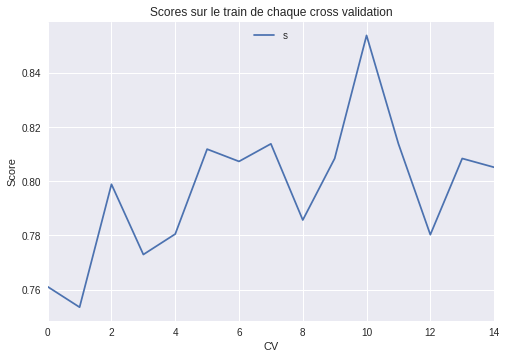

In [29]:
# Scores sur cross validation
scores = pd.DataFrame(scores)
scores.plot()

plt.xlabel('CV')
plt.ylabel('Score')
plt.title("Scores sur le train de chaque cross validation")

plt.axis()
plt.legend("scores", loc='upper center')
plt.show()

### Evaluation du modèle

In [30]:
# Je fixe le seuil qui m'a semblé être le meilleur compromis à la suite de plusieurs tests.
Y_pr = lr.predict_proba(X_test)[:, 1] > 0.7

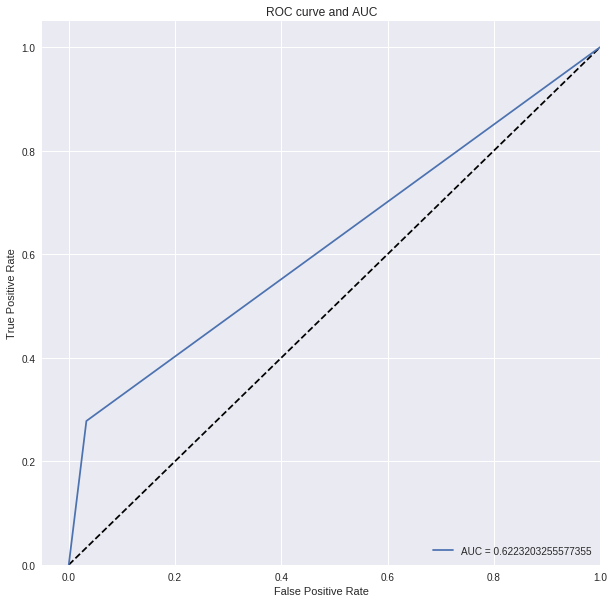

In [31]:
# overall accuracy
acc = lr.score(X_test, y_test)

# get roc/auc info
# predict_proba is the porbability that X takes a class
Y_score = lr.predict_proba(X_test)[:, 1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_pr)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))
plt.legend(loc="lower right", shadow=True, fancybox=True)
plt.title('ROC curve and AUC')
plt.show()

In [32]:
mc_lr = confusion_matrix(y_test, Y_pr)
mc_lr

array([[4435,  152],
       [  26,   10]])

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, Y_pr).ravel()
tn, fp, fn, tp

(4435, 152, 26, 10)

* Ici le modèle prédit moins de vrais positifs mais vise un peu plus juste en ayant moins de faus positifs que sur le random forest.
* La précision (P = VP/(VP+FP)) est un peu meilleure sur la logit.

In [34]:
recall = recall_score(y_test, Y_pr, average='macro')
print("recall : ", recall)

recall :  0.622320325558


In [35]:
precision = precision_score(y_test, Y_pr, average='macro') 
print("precision : ", precision)

precision :  0.52795005272


In [36]:
F1_score = (2 * (recall * precision)) / (precision + recall)
F1_score

0.57126403477235221

### Conclusion

Je trouve que globalement les précisions ne sont que très moyennes. Le problème de précision des deux modèles, qui ne sont pas très bons globalement dans les deux cas, est dû à un très fort déséquilibre de la classe.

Dans notre cas de recommendations il n'est peut être pas vital d'identifier beaucoup de faux positifs. En revanche comme dans tout problèmes de classification il est tout de même plus grave de manquer des vrais positifs. L'important est en effet de bien viser notre cible. Ainsi je pense que le modèle du random forest est un peu meilleur.

Le F1 score du random forest étant 2% plus élevé je trouve ce modèle légèrement meilleur.

Il faut aussi apprécier en fonction du cas. Il est important de souligner que la régression logistique prédit presque 3 fois moins de faux positifs.

In [37]:
y_pred = pd.DataFrame(y_pred)
Y_pr = pd.DataFrame(Y_pr)
y_test = pd.DataFrame(y_test)

In [38]:
result = pd.concat([y_pred, Y_pr, y_test], names=['rf', 'lr', 'contrib'], axis=1)

In [39]:
# Export des prédictions
result.to_csv(path_or_buf='./prédictions.csv', sep=',')

### Pistes d'améliorations possibles

* Appronfondir la recherche au niveaux des features.
* Limiter l'overfitting en rééquilibrant la classe (oversampling).
* Grid search pour trouver les meilleurs paramètres.
* Stratified k fold afin de proportionner les 1 dans les k fold pour la validation croisée.